# TocoPatch Filter Noise

In [1]:
import pickle
import os
from pprint import pprint
import datetime
import copy
import numpy as np
import scipy.signal
from matplotlib import pyplot as plt
import sys

In [2]:
sys.path.append('/Users/doug/Documents/GitHub/LowCostCTG/CombinedRecorder')

In [3]:
from libUC import compressSig, findUC, normalizeUC

In [4]:
from libTocopatchSignal import ProcessUC, isolateUC, UC_DEFAULT_PARAMS

In [5]:
from libFilterUC import filterArtfactsUC, removeSpikes

# Code

In [6]:
def showSummarySignal(sig, ts, N=15, allPct=[10, 20, 30, 40]):

    #filtered = np.abs(filtered)
    plt.figure(figsize=(15, 2))
    plt.title('summarized filtered signal for width: {} sec'.format(2*N))
    
    for pct in allPct:
        sig = removeSpikes(sig, pct, N, freq=None)
        plt.plot(ts, sig)
    plt.xlim(ts[0],ts[-1])
    plt.ylim(0,)
    plt.show()   

In [7]:
def showAnnotatedPlot(posMin, uc, filtered, allUC, 
                      thresh_base, thresh, color='b', title='After'):
    
    ymax = np.max(filtered)
    scale = np.max(uc)/ymax
    
    plt.figure(figsize=(15, 2))
    plt.title(title)
    plt.plot(posMin, uc, c=color, lw=1.5)
    plt.plot(posMin, scale*filtered, c='g', alpha=0.125)
        
    plt.plot([0, posMin[-1]], [thresh_base, thresh_base], color+'--')
    plt.plot([0, posMin[-1]], [thresh, thresh], 'r--')

    for j in range(int(posMin[-1])):
        if j % 5 == 0:
            plt.plot([j,j], [-ymax,ymax], 'k', alpha=0.25)
        else:
            plt.plot([j,j], [-ymax,ymax], 'k', alpha=0.1)

    for j in allUC:
        plt.plot([j,j], [-ymax,ymax], color, lw=2)

    plt.xlabel('time in min')
    plt.xlim(posMin[0], posMin[-1])
    plt.ylim(0,np.max(uc))
    plt.show()

In [8]:
def showAllContractions(entries, squelchFactor=3, minThresh=5, **kwargs):
    print 'kwargs:', kwargs

    for name, key in entries:
        with open(path+'/'+key+'/recordings_data.p', 'r') as f:
            detail = pickle.load(f)
        if not detail:
            continue
        #if 'deleteme' in name or '6' not in name or 'pt a' not in name:
        if 'deleteme' in name:
            continue

        print '-'*40
        print name, ':'
        for k, v in detail.items():
            fname = '{}/{}/{}.p'.format(path, key, v['uuid'])
            print '{}/{}.p'.format(key, v['uuid'])
            #print 'Comments:', data[key]['comment']
            with open(fname, 'r') as f:
                recording = pickle.load(f)

            if 'uc' not in recording or 'pos' not in recording['uc']:
                print
                print '** Skipped '+'*'*40
                print
                continue

            print recording['uc'].keys()
            posSec = recording['uc']['pos']
            posMin = recording['uc']['posMin']

            if len(posSec) == 0 or posMin[-1] < 10:
                print
                print '** Skipped '+'*'*40
                print
                continue

            raw = recording['uc']['raw']
            fs = 1.0/(posSec[1] - posSec[0])

            filtered, uc, alt_uc = isolateUC(raw, fs, **UC_DEFAULT_PARAMS)

            thresh = np.percentile(np.abs(filtered), 95)*2
            if True:
                filteredU = np.copy(filtered)
                filteredU[filteredU > thresh] = thresh
                filteredU[filteredU < 0] = 0

                filteredL = -filtered
                filteredL[filteredL > thresh] = thresh
                filteredL[filteredL < 0] = 0

                filtered = filteredU + filteredL

            ymax = thresh
            
            for N in [10, 15, 20, 25]:
                showSummarySignal(filtered, posMin, N=N,
                                  allPct=[10, 20, 30, 40])

#             showSummarySignal(filtered, posMin, N=15)
#             showSummarySignal(filtered, posMin, N=20)
#             showSummarySignal(filtered, posMin, N=25)
            #showSummarySignal(filtered, N=30)

            plt.figure(figsize=(15, 2))
            plt.title('{} -- Filtered Raw Signal'.format(name))
            plt.plot(posMin, filtered)
            for j in range(int(posMin[-1])):
                if j % 5 == 0:
                    plt.plot([j,j], [-ymax,ymax], 'k', alpha=0.5)
                else:
                    plt.plot([j,j], [-ymax,ymax], 'k', alpha=0.1)
            plt.xlabel('time in min')
            plt.xlim(posMin[0], posMin[-1])
            plt.ylim(0,ymax+1)
            plt.show()

            allIdx, allUC = findUC(uc, posMin)
            medUC = np.median(uc)
            squelchMag = max(minThresh, medUC*squelchFactor)

            if minThresh > thresh*squelchFactor:
                print '*** Threshold set to min abs value -- abs: {:0.0f} vs rel: {:0.0f}'.format(
                    minThresh, medUC*squelchFactor)

            maxVal = np.max(uc)
            if  maxVal < squelchMag:
                print '*** All values below  threshold -- max: {:0.0f} vs thresh: {:0.0f}'.format(
                    maxVal, squelchMag)
            if  maxVal < minThresh:
                print '*** All values below minimum threshold -- max: {:0.0f} vs thresh: {:0.0f}'.format(
                    maxVal, minThresh)


            showAnnotatedPlot(posMin, uc, filtered, [], 
                              medUC, squelchMag, title='')



            print
            print '*'*40
            print

# Analysis

In [9]:
#path = '/Users/doug/Documents/tocopatch_recordings'
#path = '/Users/doug/Documents/GitHub/Malawi_ctg_db'
path = '/Users/doug/Documents/GitHub/Malawi_ctg_db_user2'

In [10]:
with open(path+'/patient_data.p', 'r') as f:
    data = pickle.load(f)

In [11]:
entries = [ ['{} -- {}'.format(v['last_name'].lower(), v['first_name'].lower()), k]
           for k, v in data.items() 
           if v['last_name'].lower() not in ['sample', 'null'] 
           and '3ed0e7e9' not in v['last_name']
           and 'bb3f26f2' not in v['last_name']
          ]
entries = sorted(entries, reverse=True)

kwargs: {}
----------------------------------------
august, 2018 -- pt bb :
3d12abdc-e504-4a9c-9ffb-3c5e739fd10e/9404b533-d792-41be-9b67-a4adc39bf727.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']

** Skipped ****************************************

----------------------------------------
august 9, 2018 -- pt f :
3331a782-3057-401c-9c6a-2e0feb7abef2/d2b5181b-8f79-4b5d-b7c6-1783510ff643.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']


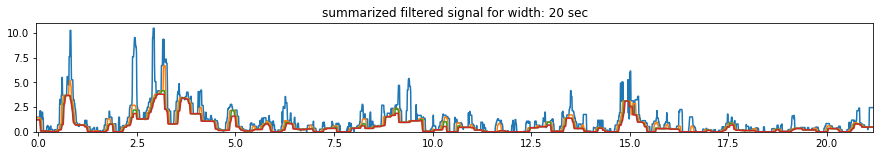

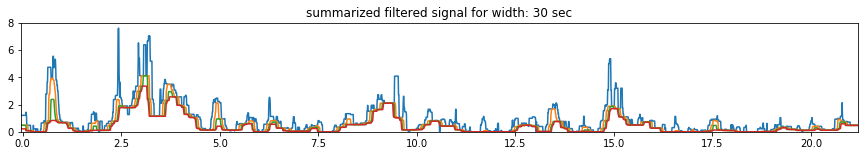

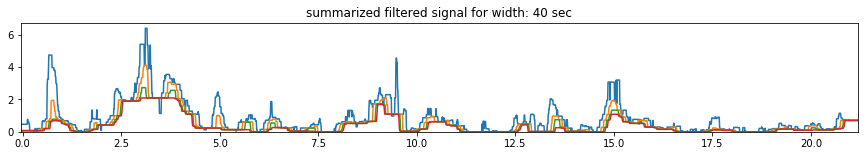

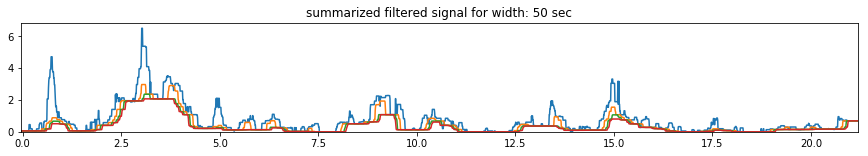

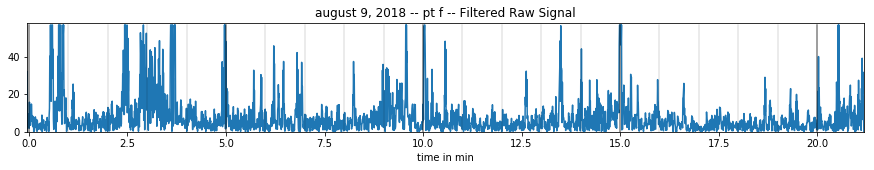

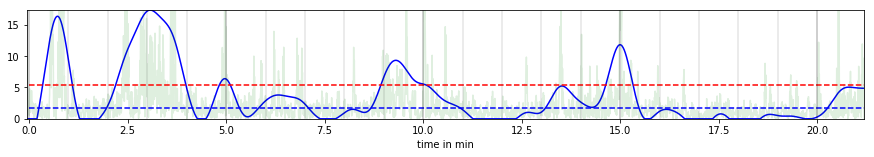


****************************************

----------------------------------------
august 9, 2018 -- pt e :
5c85bad4-6657-42e0-83ad-a7dc73a5343c/0ed82838-a510-42b3-9db1-352b1081ebfc.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']

** Skipped ****************************************

5c85bad4-6657-42e0-83ad-a7dc73a5343c/b8957c71-2fef-4142-a3b4-bb36285d8286.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']

** Skipped ****************************************

5c85bad4-6657-42e0-83ad-a7dc73a5343c/901a67b7-f367-42e4-a167-7b26c3b43da2.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']

** Skipped ****************************************

----------------------------------------
august 9, 2018 -- pt d :
a0f0df7e-87ad-44fd-b01a-d0ba0b6a6705/234ddc41-b8b7-4b84-a86e-8cd0b685cdd3.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']


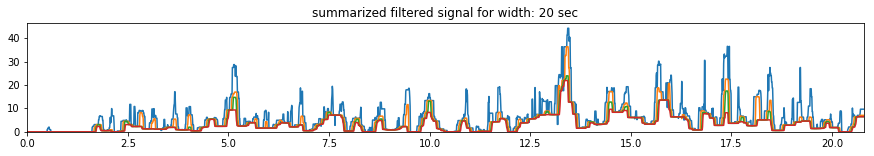

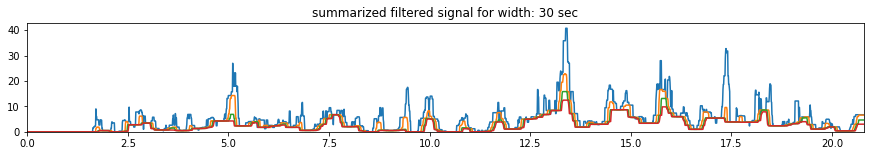

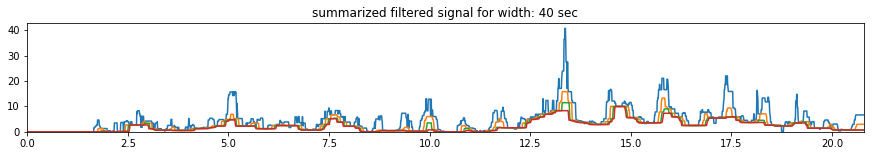

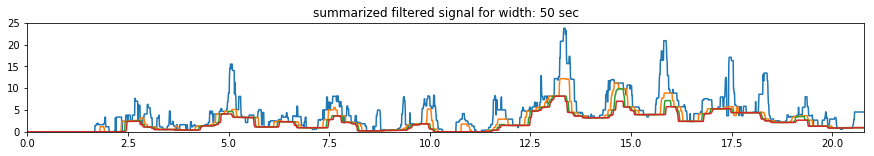

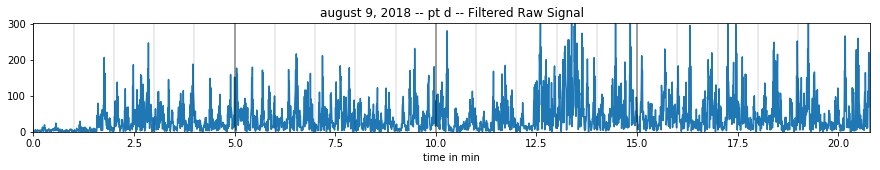

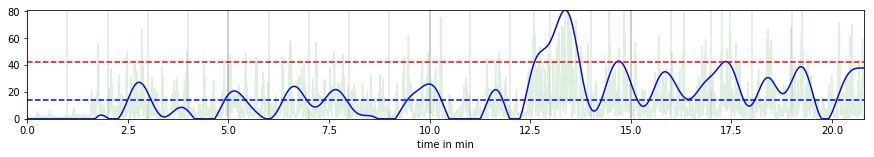


****************************************

----------------------------------------
august 9, 2018 -- pt b :
f7b17628-a4f1-481a-ad6e-1daee0df3734/42009ac5-cb34-4ef2-8610-c01bda4368c5.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']


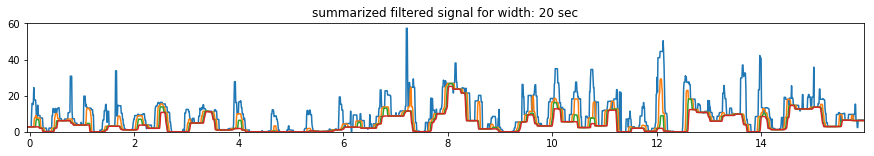

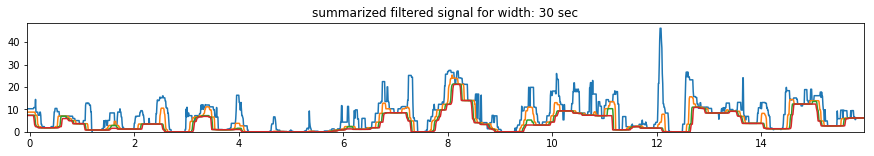

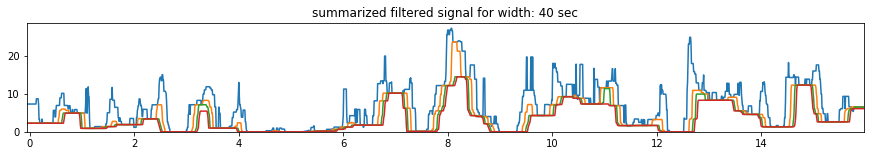

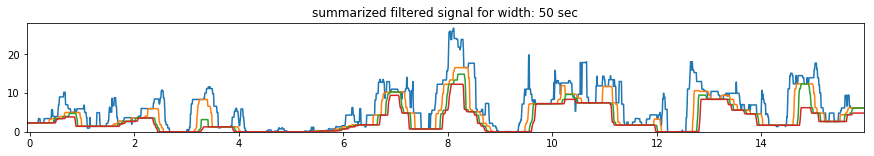

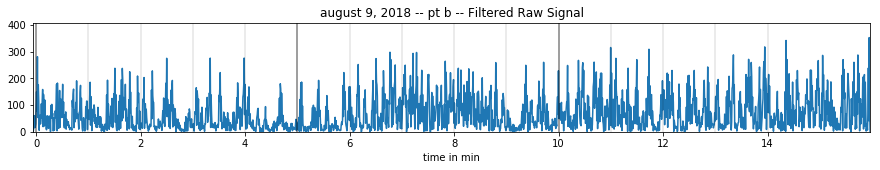

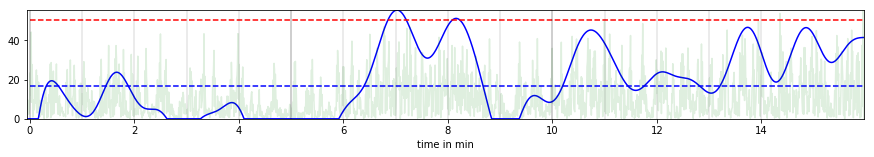


****************************************

----------------------------------------
august 9, 2018 -- pt a :
906d2e3f-e391-4cbf-a324-4afdfd917574/668a744e-65a0-49b5-abd9-ede5741f48df.p
['pos', 'raw', 'uc', 'filtered', 'posMin', 'alt_uc']


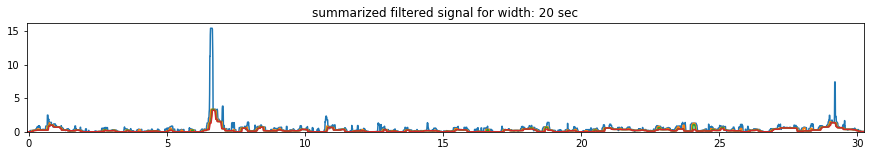

In [ ]:
showAllContractions(entries)